<a href="https://colab.research.google.com/github/zhouchun0105/Bitcoin-Price-and-Movement-Prediction/blob/main/BA780.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Packages**

In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import datetime as datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#**Data Cleaning**

Import Dataset

In [53]:
df = pd.read_csv("bitcoin.csv") 

Modify Timestamp

In [54]:
# Change the Timestamp column attribute to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
# Enable to refer to the row by index 
df = df.set_index('Timestamp')

Spot the missing values

In [60]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]


Fill in the missing data

In [62]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    
fill_missing(df)

Remove NA rows

In [44]:
df = df.dropna()

Add `Price` column by averaging Low and Close

In [45]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)

Add `Return` Column by calculating the difference from now to previous second's `Price`

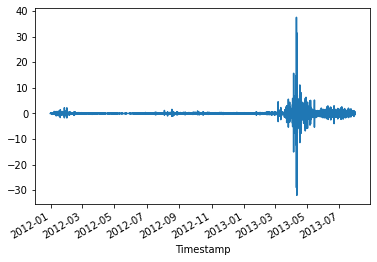

In [46]:
df["Return"] = df["Price"].diff()
df["Return"].plot()

Add `Direction` column showing if bitcoin price is going up or down.

In [47]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

Add `Percentage_Return` column to show the perentage return per seconds

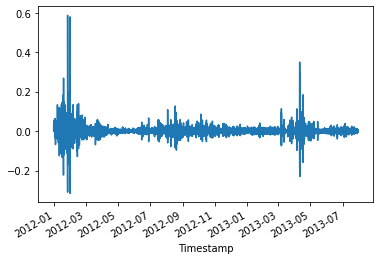

In [48]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Percentage_Return"].plot()

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [49]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)
df.dropna()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,4.390,0.000,Down,0.000000,0.033030,0.009923,0.000000,0.056769,0.033058
2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,4.535,0.145,Up,0.033030,0.009923,0.000000,0.056769,0.033058,0.000000
2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,4.580,0.045,Up,0.009923,0.000000,0.056769,0.033058,0.000000,0.064000
2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,4.580,0.000,Down,0.000000,0.056769,0.033058,0.000000,0.064000,-0.033835
2012-01-01 15:28:00,4.84,4.84,4.84,4.84,10.000000,48.400000,4.840000,4.840,0.260,Up,0.056769,0.033058,0.000000,0.064000,-0.033835,0.023346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-30 07:04:00,93.62,93.62,93.62,93.62,1.240000,116.088800,93.620000,93.620,-0.010,Down,-0.000107,0.003311,-0.002449,0.000000,0.000000,-0.000854
2013-07-30 07:05:00,93.93,93.93,93.93,93.93,0.125093,11.750000,93.930000,93.930,0.310,Up,0.003311,-0.002449,0.000000,0.000000,-0.000854,0.000855
2013-07-30 07:14:00,93.70,93.70,93.70,93.70,0.162669,15.242085,93.700000,93.700,-0.230,Down,-0.002449,0.000000,0.000000,-0.000854,0.000855,-0.001387


Cleaned Dataset Display

In [50]:
df.shape

(175472, 16)

In [51]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,4.390,NaN,Down,NaN,0.000000,0.033030,0.009923,0.000000,0.056769
2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,4.390,0.000,Down,0.000000,0.033030,0.009923,0.000000,0.056769,0.033058
2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,4.535,0.145,Up,0.033030,0.009923,0.000000,0.056769,0.033058,0.000000
2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,4.580,0.045,Up,0.009923,0.000000,0.056769,0.033058,0.000000,0.064000
2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,4.580,0.000,Down,0.000000,0.056769,0.033058,0.000000,0.064000,-0.033835


#**Exploratory Data Analysis**

In [68]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


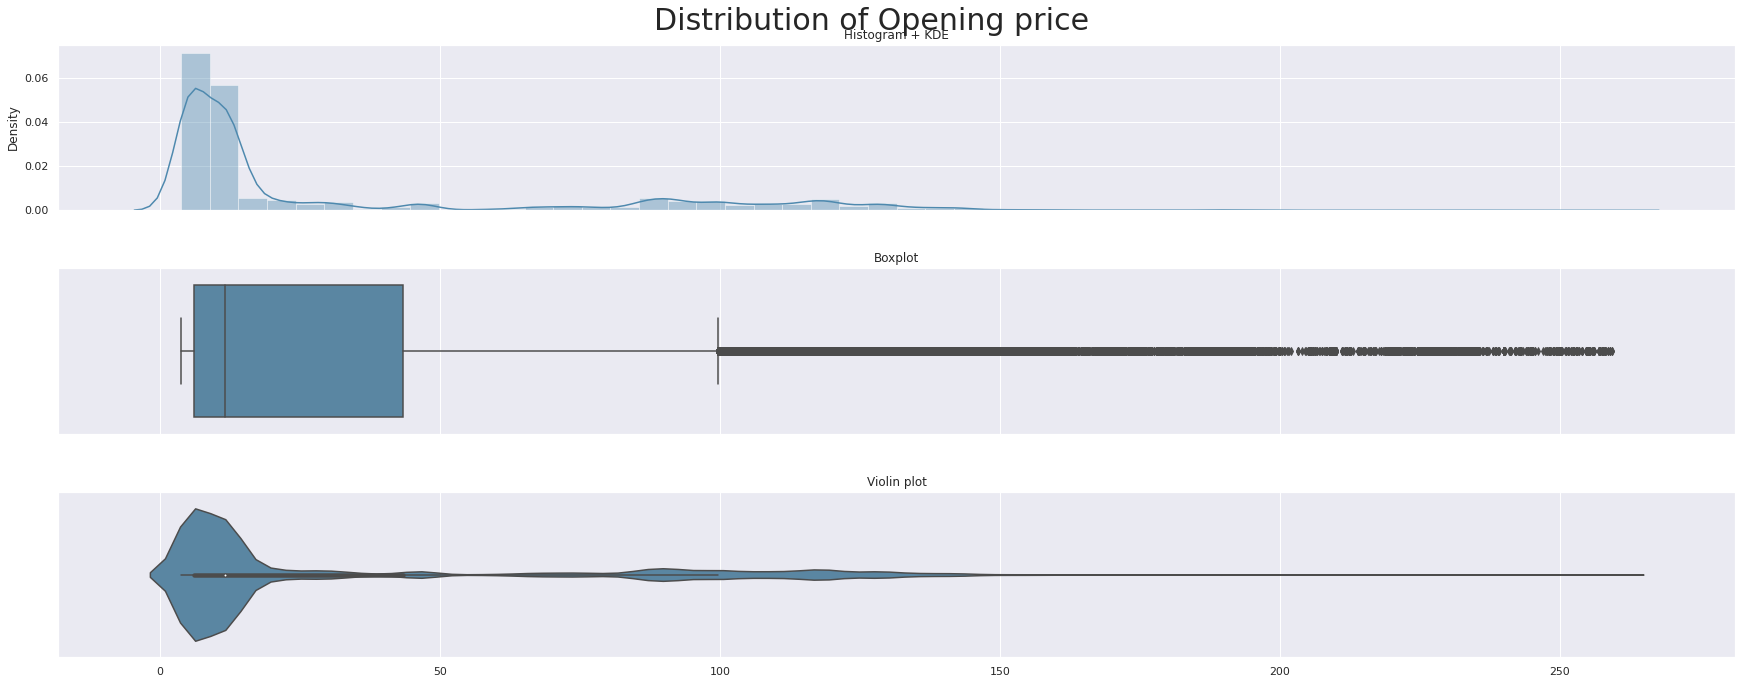

In [70]:
triple_plot(df['Open'],'Distribution of Opening price',custom_colors[0])

# **LSTM Model**

LSTM stands for long short-term memory networks. It is a variety of recurrent neural network (RNN) in the deep learning field. LSTM is effective when predicting sequence of data.

#**References**

1. "Bitcoin Price Prediction with LSTM". Ansel D'souza. https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-with-lstm